In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from feature_engine.selection import SelectByShuffling

# Hyperparameter Tuning (hyperopt)
from hyperopt import tpe,hp,Trials,space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll import scope


In [2]:
df = pd.read_csv("data/clustered_data.csv")
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.0000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.0000,0.0,2784.552848,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.1700,0.0,0.000000,1.000000,0.750000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,3
3,1666.670542,0.722223,1499.00,1443.5125,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12,2
4,817.714335,1.000000,16.00,16.0000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [3]:
df.shape

(8950, 18)

In [4]:
X = df.drop("cluster", axis=1)
y = df["cluster"]

Define RandomForestCladdifier model

In [5]:
rf = RandomForestClassifier(random_state=42)

In [6]:
shuf = SelectByShuffling(
    estimator=rf,
    scoring="accuracy",
    threshold=0.01,
    cv=3,
    random_state=1
)

In [7]:
Xt = shuf.fit_transform(X,y)

In [8]:
shuf.initial_model_performance_

np.float64(0.9549720534323635)

Performance Drift

In [9]:
pd.DataFrame.from_dict(shuf.performance_drifts_, orient="index").sort_values(0, ascending=False)

,0
PURCHASES_TRX,0.042459
BALANCE,0.039106
PURCHASES,0.035531
MINIMUM_PAYMENTS,0.023017
ONEOFF_PURCHASES,0.015196
PURCHASES_FREQUENCY,0.014414
CASH_ADVANCE,0.014413
PAYMENTS,0.013631
CASH_ADVANCE_FREQUENCY,0.010279
ONEOFF_PURCHASES_FREQUENCY,0.010056


Plotting Performance Drift

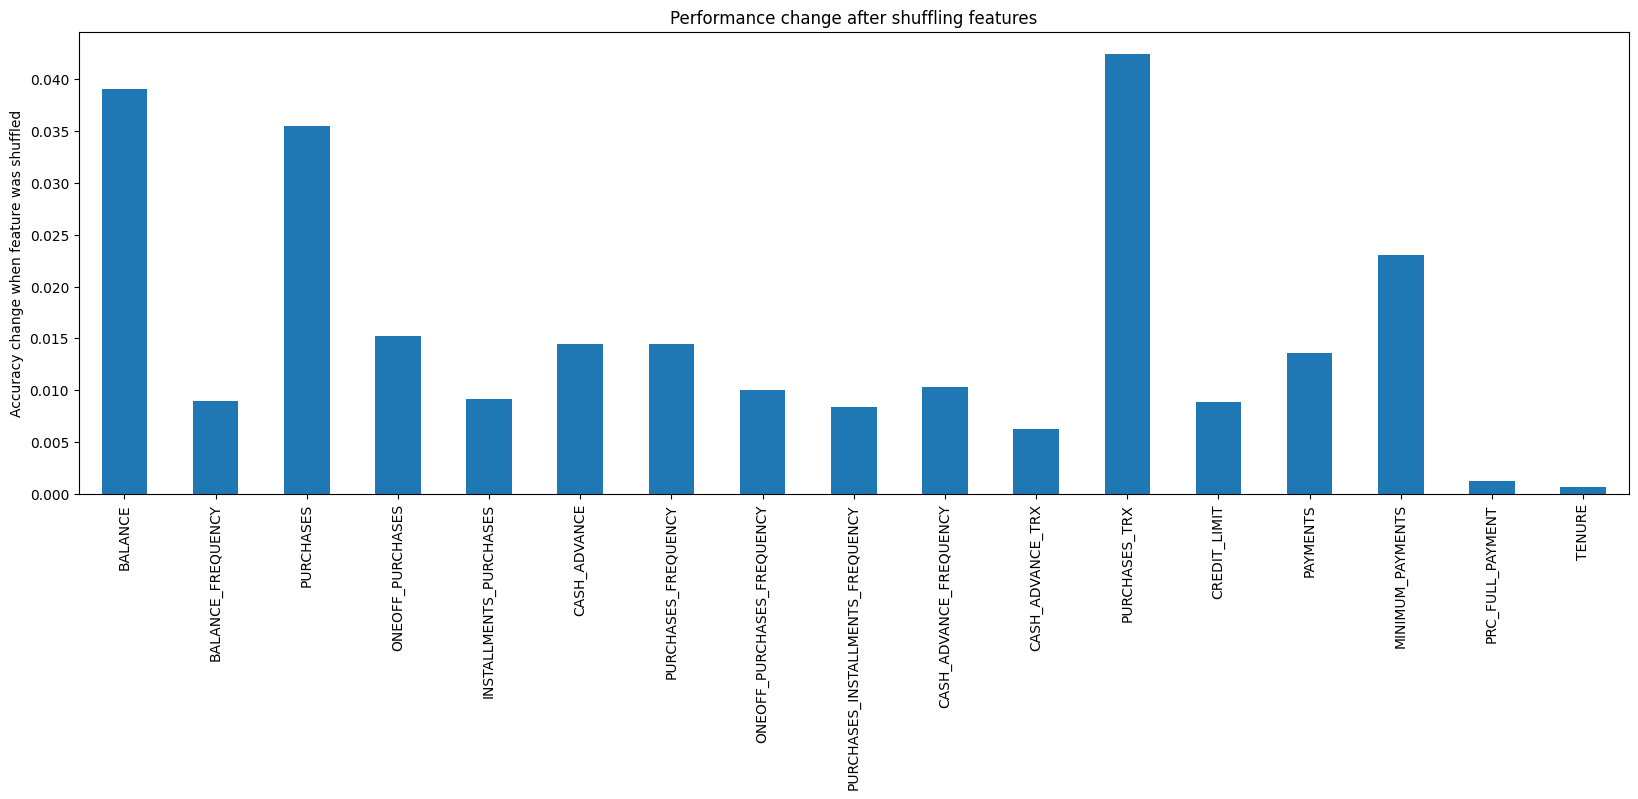

In [10]:
# Changes in performance after shuffling each feature

pd.Series(shuf.performance_drifts_).plot.bar(figsize=(20,6))
plt.title("Performance change after shuffling features")
plt.ylabel("Accuracy change when feature was shuffled")
plt.show()

Features which come under 1% performance drift

In [11]:
shuf.features_to_drop_

['BALANCE_FREQUENCY',
 'INSTALLMENTS_PURCHASES',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'CREDIT_LIMIT',
 'PRC_FULL_PAYMENT',
 'TENURE']

X after dropping less important features

In [12]:
Xt.head()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS
0,40.900749,95.40,0.0000,0.000000,0.166667,0.000000,0.000000,2,201.802084,139.509787
1,3202.467416,0.00,0.0000,2784.552848,0.000000,0.000000,0.250000,0,4103.032597,1072.340217
2,2495.148862,773.17,773.1700,0.000000,1.000000,0.750000,0.000000,12,622.066742,627.284787
3,1666.670542,1499.00,1443.5125,205.788017,0.083333,0.083333,0.083333,1,0.000000,312.343947
4,817.714335,16.00,16.0000,0.000000,0.083333,0.083333,0.000000,1,678.334763,244.791237


Hyperopt: Distributed Hyperparameter Optimization

In [13]:
def rf_objective(params):
    model = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    acc = cross_val_score(model, Xt, y, scoring="accuracy").mean()
    return acc

In [14]:
params = {
    "n_estimators": hp.randint("n_estimators", 100, 500),
    "max_depth": hp.randint("max_depth", 5, 40),
    "min_samples_leaf":hp.randint("min_samples_leaf",2,10),
    "min_samples_split":hp.randint("min_samples_split",2,10),
    "criterion":hp.choice("criterion",["gini","entropy"]),
    "max_features":hp.choice("max_features",["sqrt", "log2"])   
}

rf_trials = Trials()

best_rf = fmin(
         fn=rf_objective,
         space=params,
         algo=tpe.suggest,
         trials=rf_trials,
         max_evals=100,
         rstate=np.random.default_rng()
)

100%|██████████████████████████████████████████████| 100/100 [24:26<00:00, 14.67s/trial, best loss: 0.9120670391061452]


In [15]:
# 18 features = 95.49%
# 10 features = 91.20%

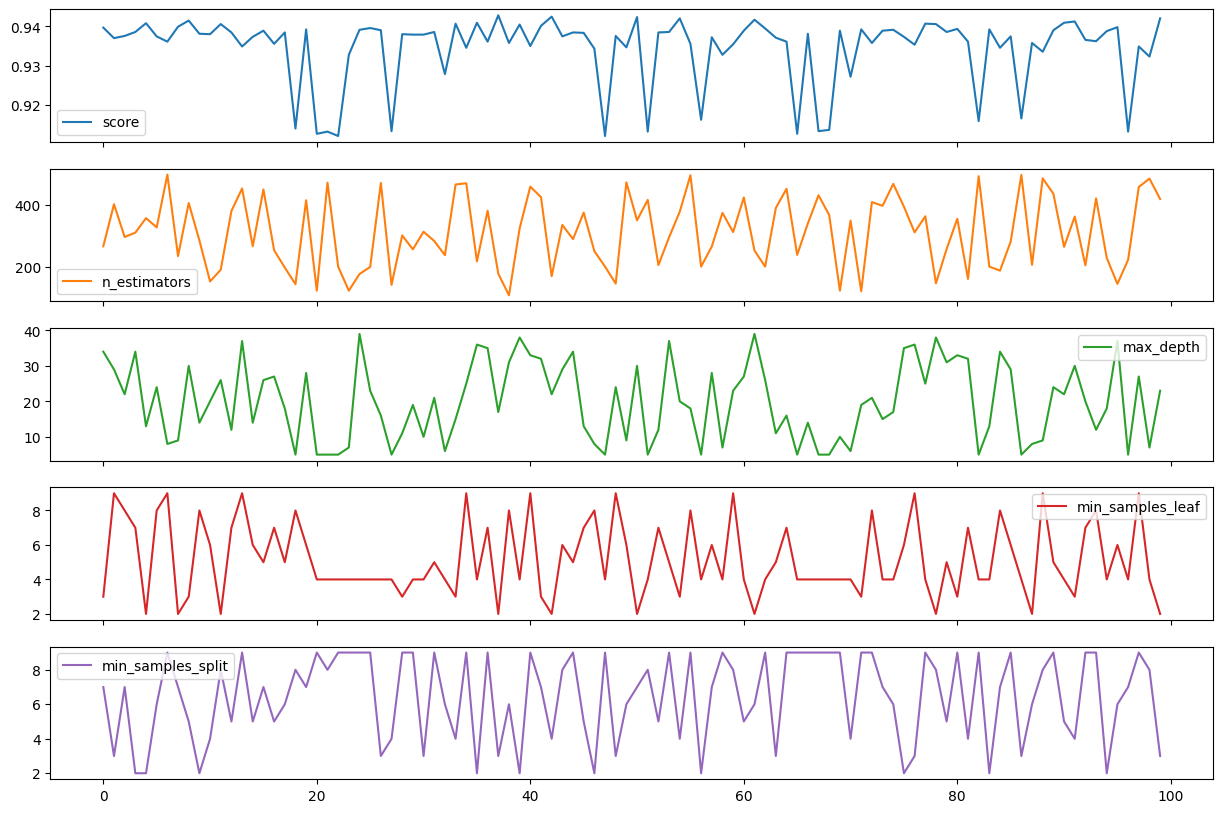

In [18]:
# Visualization of Hyperparameter tuning
tpe_results = np.array([[x["result"]["loss"],
                         x["misc"]["vals"]["n_estimators"][0],
                         x["misc"]["vals"]["max_depth"][0],
                         x["misc"]["vals"]["min_samples_leaf"][0],
                         x["misc"]["vals"]["min_samples_split"][0]] for x in rf_trials.trials])


tpe_results_df= pd.DataFrame(tpe_results,
                  columns=["score", "n_estimators", "max_depth", "min_samples_leaf", "min_samples_split"])
tpe_results_df.plot(subplots=True, figsize=(15,10))
plt.show()

In [19]:
best_rf

{'criterion': np.int64(0),
 'max_depth': np.int64(5),
 'max_features': np.int64(0),
 'min_samples_leaf': np.int64(4),
 'min_samples_split': np.int64(9),
 'n_estimators': np.int64(200)}

Split into Train and Test Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, random_state=42, test_size=0.3)

X_train

,BALANCE,PURCHASES,ONEOFF_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS
5831,649.896506,2715.8725,1443.5125,191.376535,0.916667,0.666667,0.166667,41,4177.921543,219.441278
2244,2382.328208,899.5800,413.2800,450.252732,1.000000,0.250000,0.166667,34,850.186851,1212.047288
4205,1119.157048,133.9000,133.9000,269.234406,0.166667,0.166667,0.250000,3,427.355150,320.855529
7933,0.000000,136.8000,0.0000,0.000000,1.000000,0.000000,0.000000,12,127.996550,312.343947
8462,20.620429,169.6600,0.0000,0.000000,0.750000,0.000000,0.000000,9,192.185764,145.811693
...,...,...,...,...,...,...,...,...,...,...
5734,1079.097023,247.4400,0.0000,0.000000,1.000000,0.000000,0.000000,12,503.445403,302.481716
5191,833.541256,0.0000,0.0000,1422.637361,0.000000,0.000000,0.333333,0,180.104404,282.085369
5390,40.247238,0.0000,0.0000,909.480894,0.000000,0.000000,0.083333,0,3578.648701,69.271137
860,0.000000,199.8800,0.0000,0.000000,0.750000,0.000000,0.000000,14,0.000000,312.343947


In [21]:
rf = RandomForestClassifier(criterion="gini",
                            max_depth=37,
                            max_features="sqrt",
                            min_samples_leaf=2,
                            min_samples_split=4,
                            n_estimators=146
                           )

Model Report

In [22]:
best_model = rf.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Random Forest Classifier")
print("Accuracy Score Value: {:.4f}".format(score))
print(cr)

Random Forest Classifier
Accuracy Score Value: 0.9378
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       818
           1       0.91      0.94      0.92       511
           2       0.98      0.98      0.98       736
           3       0.91      0.90      0.90       620

    accuracy                           0.94      2685
   macro avg       0.93      0.94      0.94      2685
weighted avg       0.94      0.94      0.94      2685



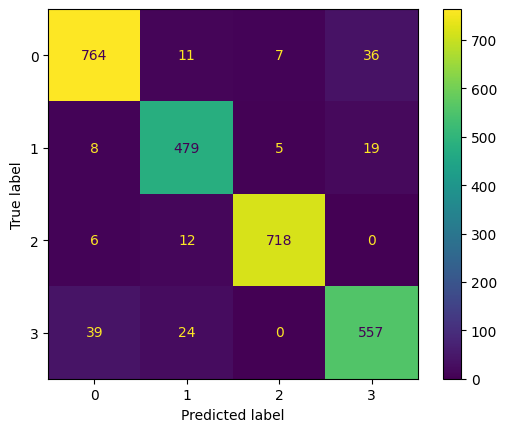

In [23]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

Visualize Tree

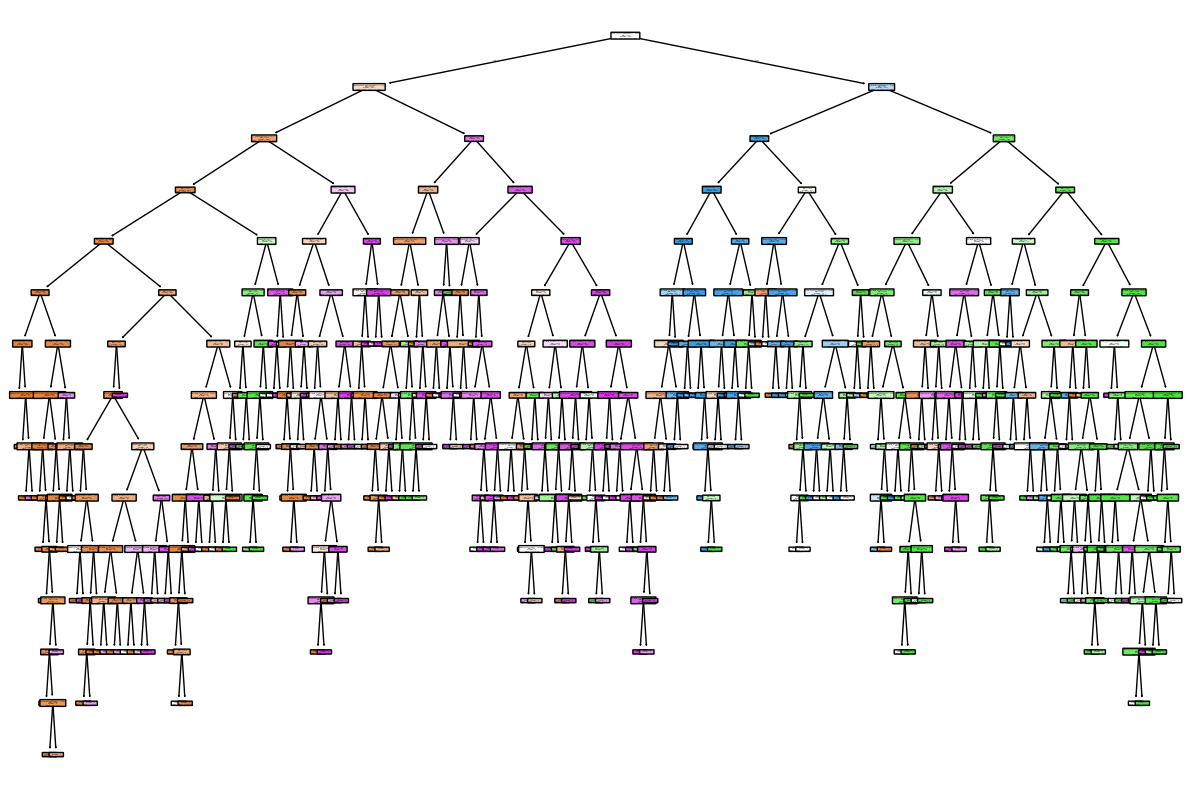

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(15,10))
plot_tree(best_model.estimators_[0],
         feature_names=Xt.columns,
         filled=True, impurity=True,
         rounded=True)
plt.show()